## Counting mentions of Wikipedia articles in Reddit submission titles

### Prerequisites

1. Download a dump of Wikipedia's articles, named `enwiki-{date_string}-pages-articles-multistream.xml.bz2`
2. Download the `enwiki-{date_string}-pages-articles-multistream-index.txt.bz2` file
3. Move those files into the same folder, removing the `enwiki-{date_string}` prefix
4. Process the `xml.bz2` file into a Parquet file using `wikiplain.load_bz2`
5. Run `PageRank.ipynb`

In [1]:
import asyncio
import glob
import gzip
import io
import itertools
import json
import math
import operator
import os
import pickle
import random
import re
import shutil
import socket
import struct
import subprocess
import sys
import tarfile
import time
from collections import ChainMap, defaultdict, deque
from contextlib import asynccontextmanager, contextmanager
from dataclasses import dataclass
from datetime import datetime
from enum import Enum, auto
from functools import lru_cache, partial
from urllib.parse import urlencode, urlsplit, quote as urlquote, unquote as urlunquote
from xml.sax.saxutils import unescape as xml_unescape
from typing import Any, Awaitable, Callable, Literal, TypeVar

import cbor2
import httpx
import ijson
import matplotlib.pyplot as plt
import mmh3
import numpy as np
import pandas as pd
import pypocketmap as pkm
import pyarrow
import pyarrow.parquet as pq
import polars as pl
import seaborn as sns
import sqlalchemy as sa
import scipy.sparse
import toolz
from dotenv import load_dotenv
from ipywidgets import interact
from spacy.lang.en import English
from sqlalchemy import create_engine
from sqlalchemy.sql import column as sqlcolumn, select, text as sqltext
from tqdm.auto import tqdm
from zstandard import ZstdDecompressor, ZstdDecompressionReader
from arsenal.datastructures.unionfind import UnionFind
from arsenal.datastructures.heap import MinMaxHeap

import wikiplain
from special_cases import SECOND_LEVEL_DOMAINS
from nbhelpers.polars import pager, searcher
from umbc_web.process_possf2 import PENN_TAGS, PENN_TAGS_BY_ID

In [2]:
load_dotenv()

True

In [3]:
pl.Config.set_fmt_str_lengths(160)

polars.config.Config

In [4]:
class RedditRankFiles:
    def __init__(self, date_string):
        self.date_string = date_string
        self.enwiki_dir = f"{os.environ['ENWIKI_DIR']}/{date_string}"
        self.parquet_dir = os.environ.get('ENWIKI_PARQUET_DIR', self.enwiki_dir)
        self.reddit_dir = f"{os.environ['REDDIT_DIR']}"
        try:
            os.mkdir(f"{self.enwiki_dir}/pagerank")
        except FileExistsError:
            pass
    
    @property
    def enwiki_parquet_filename(self):
        return f"{self.parquet_dir}/enwiki_{self.date_string}.parquet"
    
    @property
    def pagerank_parquet_filename(self):
        return f"{self.parquet_dir}/enwiki_{self.date_string}_pagerank.parquet"
    
    @property
    def redditrank_parquet_filename(self):
        return f"{self.parquet_dir}/enwiki_{self.date_string}_redditrank.parquet"
    
    @property
    def enwiki_tokenized_arrow_filename(self):
        return f"{self.parquet_dir}/enwiki_tokenized.arrow"
    
    @property
    def enwiki_tokenized_database_uri(self):
        return f"sqlite:///{self.parquet_dir}/enwiki_tokenized_{self.date_string}.sqlite"

    @property
    def nub_filename(self):
        return f"{self.enwiki_dir}/pagerank/nub.bin"
    
    @property
    def id_map_filename(self):
        return f"{self.enwiki_dir}/pagerank/id_map.bin"
    
    @property
    def id_map2_filename(self):
        return f"{self.enwiki_dir}/pagerank/id_map2.bin"
    
    @property
    def dense_id_arr_filename(self):
        return f"{self.enwiki_dir}/pagerank/dense_id_arr.npy"
    
    @property
    def edge_filename_pattern(self):
        return f"{self.enwiki_dir}/pagerank/edges_*.npz"
    
    def edge_filenames(self, num_partitions):
        return [
            f"{self.enwiki_dir}/pagerank/edges_{i}.npz"
            for i in range(num_partitions)
        ]
    
    @property
    def hatedge_filename_pattern(self):
        return f"{self.enwiki_dir}/pagerank/hatedges_*.npy"
    
    def hatedge_filenames(self, num_partitions):
        return [
            f"{self.enwiki_dir}/pagerank/hatedges_{i}.npy"
            for i in range(num_partitions)
        ]
    
    @property
    def hatcheck_arr_filename(self):
        return f"{self.enwiki_dir}/pagerank/hatcheck_arr.npy"

    @property
    def in_degree_filename(self):
        return f"{self.enwiki_dir}/pagerank/in_degree.npy"
    
    @property
    def out_degree_filename(self):
        return f"{self.enwiki_dir}/pagerank/out_degree.npy"
    
    @property
    def disambig_arr_filename(self):
        return f"{self.enwiki_dir}/pagerank/disambig_arr.npy"
    
    @property
    def top_cite_domains_filename(self):
        return f"{self.enwiki_dir}/pagerank/top_cite_domains.bin"

    @property
    def reddit_relevance_filename_pattern(self):
        return f"{self.enwiki_dir}/pagerank/RS_*.npy"
    
    def adjacency_filename(self, partition):
        return f"{self.enwiki_dir}/pagerank/adjacency_{partition}.npz"
    
    def adjacency_filenames(self, num_partitions):
        return [self.adjacency_filename(i) for i in range(num_partitions)]
    
    @property
    def template_id_maps_filename(self):
        return f"{self.enwiki_dir}/pagerank/template_id_maps.pkl"

In [5]:
files = RedditRankFiles("20240401")

### Re-use outputs computed by PageRank.ipynb

1. Pages with the same title
2. `id_map` from non-redirecting article titles to node number, and `id_map2` from redirecting article titles to node number

In [23]:
pqf = pq.ParquetFile(files.enwiki_parquet_filename)

In [6]:
with open(files.nub_filename, "rb") as fp:
    overwritten, pqf_size = cbor2.load(fp)

In [7]:
def iterdecode(f):
    decoder = cbor2.CBORDecoder(f)
    while True:
        try:
            yield decoder.decode()
        except EOFError:
            return

In [8]:
with open(files.id_map_filename, "rb") as fp:
    id_map = pkm.create(str, int)
    for k, v in iterdecode(fp):
        id_map[k] = v
with open(files.id_map2_filename, "rb") as fp:
    id_map2 = pkm.create(str, int)
    for k, v in iterdecode(fp):
        id_map2[k] = v
# with open(files.dense_id_arr_filename, "rb") as fp:
#     dense_id_arr = np.load(fp)

In [9]:
N = len(id_map)
# ids_concat = pyarrow.array(itertools.chain(id_map.keys(), id_map2.keys()), size=len(id_map) + len(id_map2))

In [10]:
# node_ids_concat = pyarrow.array(itertools.chain(id_map.values(), id_map2.values()), size=len(id_map) + len(id_map2), type=pyarrow.uint32())

In [11]:
LOG_PARTITION_SIZE = 16
PARTITION_SIZE = 1 << LOG_PARTITION_SIZE
NUM_PARTITIONS = math.ceil(N / PARTITION_SIZE)

In [12]:
PR = pl.read_parquet(files.pagerank_parquet_filename)
PR_value = PR["value"].to_numpy()

### Wikipedia article stats

1. Create `disambig_arr`, a simple boolean array recording whether each article is a disambiguation or set-index page.
2. Create `top_cite_domains`, the 1024 most commonly cited websites across all articles.

In [13]:
class Vec:
    def __init__(self, dtype):
        self.array = np.ndarray((1024,), dtype=dtype)
        self.length = 0
    
    @property
    def capacity(self):
        return self.array.shape[0]

    def append(self, v):
        idx = self.length
        if idx >= self.capacity:
            addsz = max(2, self.capacity)
            self.array = np.hstack((self.array, np.zeros((addsz,), dtype=self.array.dtype)))
        self.array[idx] = v
        self.length += 1

In [14]:
def chunk(iterable, size):
    """Split an iterable into list chunks of size `n`.
    
    The last chunk can be fewer than `n` elements long, but it won't be empty.
    """
    iterator = iter(iterable)
    while True:
        chunk = list(itertools.islice(iterator, size))
        if chunk:
            yield chunk
        else:
            return

def lazy_chunk(iterable, n):
    """Split an iterable into iterable chunks of size `n`.
    
    The last chunk can be fewer than `n` elements long, but it won't be empty.
    """
    iterator = iter(iterable)
    while True:
        try:
            first = next(iterator)
        except StopIteration:
            return
        yield itertools.chain([first], itertools.islice(iterator, n - 1))

In [15]:
# def get_template_id_maps():
#     redirect_group_map = UnionFind()
#     template_id_map = {}
#     for batch in tqdm(pqf.iter_batches(batch_size=100), total=math.ceil(pqf_size / 100)):
#         for aid, ns, ttl, redir in zip(batch["id"].to_numpy(), batch["ns"].to_numpy(), batch["title"].to_pylist(), batch["redirect"].to_pylist()):
#             if ns != 10 or aid in overwritten:
#                 continue
#             if redir is not None:
#                 redirect_group_map.union(ttl, redir)
#             else:
#                 assert ttl not in template_id_map, f"Expected unique titles, got second instance of {ttl}"
#                 template_id_map[ttl] = aid
#     template_id_map2 = {}
#     for group in redirect_group_map.classes():
#         centers = [ttl for ttl in group if ttl in template_id_map]
#         if len(centers) == 0:
#             continue
#         assert len(centers) == 1, str(centers)
#         for ttl in group:
#             if ttl != centers[0]:
#                 template_id_map2[ttl] = template_id_map[centers[0]]
#     return template_id_map, template_id_map2

# try:
#     with open(files.template_id_maps_filename, "rb") as fp:
#         template_id_map, template_id_map2 = pickle.load(fp)
# except FileNotFoundError:
#     template_id_map, template_id_map2 = get_template_id_maps()
#     with open(files.template_id_maps_filename, "wb") as fp:
#         pickle.dump((template_id_map, template_id_map2), fp)

In [15]:
def get_disambig_arr():
    iterator = tqdm(pqf.iter_batches(batch_size=100), total=math.ceil(pqf_size / 100))
    iterator = map(
        lambda b: zip(
            b["id"].to_numpy(),
            b["ns"].to_numpy(),
            map(operator.attrgetter("is_valid"), b["redirect"]),
            b["text"].to_pylist()
        ),
        iterator
    )
    iterator = itertools.chain.from_iterable(iterator)
    iterator = filter(lambda e: not e[2] and e[1] == 0 and e[0] not in overwritten, iterator)
    iterator = enumerate(map(operator.itemgetter(3), iterator))
    disambig_arr = np.zeros(N, dtype=np.bool_)
    for node_id, text in iterator:
        disambig_arr[node_id] = wikiplain.is_disambiguation_page(text)
    return disambig_arr

try:
    with open(files.disambig_arr_filename, "rb") as fp:
        disambig_arr = np.load(fp)
except Exception:
    disambig_arr = get_disambig_arr()
    with open(files.disambig_arr_filename, "wb") as fp:
        np.save(fp, disambig_arr)

In [16]:
!curl https://raw.githubusercontent.com/timvieira/arsenal/master/arsenal/datastructures/heap/heap.pyx

# cython: language_level=3, boundscheck=False, infer_types=True, nonecheck=False
# cython: overflowcheck=False, initializedcheck=False, wraparound=False, cdivision=True

"""
Heap data structures with optional
 - Locators
 - Top-k (Bounded heap)

"""
import numpy as np

Vt = np.double
cdef double NaN = np.nan

# TODO: Use the C++ standard library's implementation of a vector of doubles.
cdef class Vector:

    cdef public:
        int cap
        int end
        double[:] val

    def __init__(self, cap):
        self.cap = cap
        self.val = np.zeros(self.cap, dtype=Vt)
        self.end = 0

    cpdef int push(self, double x):
        i = self.end
        self.ensure_size(i)
        self.val[i] = x
        self.end += 1
        return i

    cpdef object pop(self):
        "pop from the end"
        assert 0 < self.end
        self.end -= 1
        v = self.val[self.end]
        self.val[self.end] = NaN
        return v

    cdef void grow(self):
        self.cap *= 2
        new =

In [18]:
def get_top_cite_domains():
    iterator = tqdm(pqf.iter_batches(batch_size=100), total=math.ceil(pqf_size / 100))
    iterator = map(
        lambda b: zip(
            b["id"].to_numpy(),
            b["ns"].to_numpy(),
            map(operator.attrgetter("is_valid"), b["redirect"]),
            b["text"].to_pylist()
        ),
        iterator
    )
    iterator = itertools.chain.from_iterable(iterator)
    iterator = filter(lambda e: not e[2] and e[1] == 0 and e[0] not in overwritten, iterator)
    iterator = enumerate(map(operator.itemgetter(3), iterator))
    heap = MinMaxHeap()
    heap_phases = 9
    heap_phase_size = int(N / heap_phases)
    heap_limits = [
        (heap_phase_size*i, 1024 << (heap_phases-i-1)) for i in range(heap_phases)
    ]
    assert heap_limits[-1][0] < N

    heap_phase = 0
    heap_limit = heap_limits[heap_phase][1]
    for node_id, text in iterator:
        if heap_phase+1 < heap_phases and node_id < heap_limits[heap_phase+1][0]:
            heap_phase += 1
            heap_limit = heap_limits[heap_phase][1]
            while len(heap) > heap_limit:
                heap.popmin()
        page = defaultdict(int)
        for url in wikiplain.get_cite_urls(text):
            full_domain = re.sub(r"[:/].*", "", url)
            parts = full_domain.split('.')
            if len(parts) >= 2:
                site_domain = parts[-2] + '.' + parts[-1]
                if site_domain in SECOND_LEVEL_DOMAINS:
                    if len(parts) >= 3:
                        site_domain = parts[-3] + '.' + site_domain
                    else:
                        continue
                page[site_domain] += 1
        for k, v in page.items():
            if k in heap:
                heap[k] = heap.max[k] + v
            elif len(heap) < heap_limit:
                heap[k] = v
            elif v > heap.peekmin()[1]:
                heap.popmin()
                heap[k] = v
    top_cite_domains = []
    while len(heap) > 0:
        top_cite_domains.append(heap.popmax())
    return top_cite_domains

try:
    with open(files.top_cite_domains_filename, "rb") as fp:
        top_cite_domains = cbor2.load(fp)
except Exception:
    top_cite_domains = get_top_cite_domains()
    with open(files.top_cite_domains_filename, "wb") as fp:
        cbor2.dump(top_cite_domains, fp)

In [19]:
pager(pl.DataFrame(top_cite_domains, schema=['domain', 'count']), 16)

interactive(children=(Dropdown(description='page', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, …

<function nbhelpers.polars.pager.<locals>.<lambda>(page)>

In [20]:
searcher(pl.DataFrame(top_cite_domains, schema=['domain', 'count'])
          .with_columns(pl.Series("rank", range(len(top_cite_domains)))),
         ["domain"],
         16)

interactive(children=(Text(value='', description='q'), Output()), _dom_classes=('widget-interact',))

<function nbhelpers.polars.searcher.<locals>.searcher_run(q)>

In [21]:
excluded_domains = {"imgur.com", "twitter.com", "youtube.com", "soundcloud.com",
                    "instagram.com", "amazon.com", "github.com", "vimeo.com",
                    "google.com"
                   }
top_cite_domain_set = {domain for domain, _ in top_cite_domains} - excluded_domains

In [22]:
ORDER_TAG_BITS = 3
NUM_ORDER_TAGS = 1 << ORDER_TAG_BITS
DEST_ID_BITS = 31 - ORDER_TAG_BITS
DEST_ID_MASK = (1 << DEST_ID_BITS) - 1
@lru_cache(maxsize=1)
def load_edges(partition):
    with np.load(files.edge_filenames(NUM_PARTITIONS)[partition]) as npz:
        return list(npz.values())

In [23]:
class PairVec:
    def __init__(self, dtype):
        self.array = np.ndarray((1024, 2), dtype=dtype)
        self.length = 0
    
    @property
    def capacity(self):
        return self.array.shape[0]

    def append(self, v1, v2):
        idx = self.length
        if idx >= self.capacity:
            addsz = max(2, self.capacity)
            self.array = np.vstack((self.array, np.zeros((addsz, 2), dtype=self.array.dtype)))
        self.array[idx] = [v1, v2]
        self.length += 1

In [24]:
from wikiplain import Token, TokenKind as TK

In [25]:
def split_token(tc, c):
    return [Token(kind=TK.Content, data=piece) for piece in tc.split(c)]

def split_template(line):
    finished = []
    tdepth = 0
    ldepth = 0
    tokens = wikiplain.tokenize(line)
    acc = []
    for tok in tokens:
        match tok:
            case Token(kind=TK.Content, data=tc):
                if tdepth > 0 or ldepth > 0:
                    acc.append(tok)
                elif tc != '':
                    parts = split_token(tc, '|')
                    if parts[0].data != '':
                        acc.append(parts[0])
                    if len(parts) > 1:
                        finished.append(acc)
                        if parts[-1].data != '':
                            acc = [parts.pop()]
                        for p in parts[1:]:
                            finished.append([p])
            case Token(kind=TK.LinkStart):
                ldepth += 1
                acc.append(tok)
            case Token(kind=TK.LinkEnd):
                ldepth -= 1
                acc.append(tok)
            case Token(kind=TK.TemplateStart):
                tdepth += 1
                acc.append(tok)
            case Token(kind=TK.TemplateEnd):
                tdepth -= 1
                acc.append(tok)
    if acc:
        finished.append(acc)
    return finished

def tokenlist_string(tl):
    if len(tl) != 1 or tl[0].kind != TK.Content:
        return None
    return tl[0].data

def token_fmt(tok):
    match tok:
        case Token(kind=TK.Content, data=tc):
            return tc
        case Token(kind=TK.LinkStart):
            return '[['
        case Token(kind=TK.LinkEnd):
            return ']]'
        case Token(kind=TK.TemplateStart):
            return '{{'
        case Token(kind=TK.TemplateEnd):
            return '}}'

def tokenlist_gettext(tl):
    return "".join(map(token_fmt, tl))
    
def tokenlist_startswith(tl, s):
    if len(tl) == 0 or tl[0].kind != TK.Content:
        return False
    return tl[0].data.startswith(s)

def tokenlist_links(tl):
    accs = []
    for tok in tl:
        match tok:
            case Token(kind=TK.Content, data=tc):
                if accs:
                    accs[-1].append(tc)
            case Token(kind=TK.LinkStart):
                accs.append([])
            case Token(kind=TK.LinkEnd):
                if accs:
                    yield "".join(accs.pop())

In [26]:
# linking the reader to other articles with similar titles or concepts
# that they may have been seeking instead
HATNOTE_ABOUT = 1
# placed at the top of the article or section that is the primary topic
# of a redirect, and links to other topics that are ambiguous with the
# name of that redirect
HATNOTE_REDIRECT = 2
# concise about / other uses
HATNOTE_FOR = 3
# "not to be confused with"
HATNOTE_DISTINGUISH = 4
def parse_hatnote(line):
    lst = split_template(line)
    if len(lst) == 0:
        return
    tmpl_toks, *args = lst
    tmpl = tokenlist_string(tmpl_toks)
    if not tmpl:
        return
    tmpl = tmpl[0].upper() + tmpl[1:]
    if tmpl == 'About':
        # the Latin letter|the similar Greek letter|Alpha|the similar Cyrillic letter|A (Cyrillic)|other uses
        for dest_ttl in map(tokenlist_gettext, args[2::2]):
            yield HATNOTE_ABOUT, dest_ttl
    elif tmpl == 'Redirect':
        # Achilleus|the Roman usurper with this name|Aurelius Achilleus|other uses|Achilles (disambiguation)
        for dest_ttl in map(tokenlist_gettext, args[2::2]):
            yield HATNOTE_REDIRECT, dest_ttl
    elif tmpl == 'For':
        # the racehorse|Ambiorix (horse)
        for dest_ttl in map(tokenlist_gettext, args[2::2]):
            yield HATNOTE_FOR, dest_ttl
    elif tmpl == 'Redirect-synonym':
        # Wild cranberry|[[Arctostaphylos uva-ursi]]
        for dest_ttl in map(tokenlist_gettext, args[2::2]):
            yield HATNOTE_REDIRECT, dest_ttl
    elif tmpl == 'About-distinguish':
        if len(args) > 1:
            yield HATNOTE_DISTINGUISH, tokenlist_gettext(args[1])
    elif tmpl == 'Redirect2':
        # Anarchist|Anarchists|other uses|Anarchist (disambiguation)
        for dest_ttl in map(tokenlist_gettext, args[2::2]):
            yield HATNOTE_REDIRECT, dest_ttl
    elif tmpl == 'Redirect-multi':
        # Redirect-multi|2|Oscars|The Oscar|other uses|Oscar (disambiguation)
        try:
            skip = int(tokenlist_string(args[1]))
        except (TypeError, ValueError):
            return
        for dest_ttl in map(tokenlist_gettext, args[2::2]):
            yield HATNOTE_REDIRECT, dest_ttl
    elif tmpl == 'Distinguish' or tmpl == 'Redirect-distinguish-text':
        # distinguish|text=[[Lucius Appuleius Saturninus]], a Roman demagogue, or others with the name Apuleius or [[Appuleia (gens)|Appuleius]]
        for tl in args:
            if (
                tmpl == 'Redirect-distinguish-text'
                or tokenlist_startswith(tl, 'text=')
                or tokenlist_startswith(tl, 'Text=')
            ):
                for link_inner in tokenlist_links(tl):
                    dest = link_inner.split('|', maxsplit=1)[0]
                    yield HATNOTE_DISTINGUISH, dest
            else:
                yield HATNOTE_DISTINGUISH, tokenlist_gettext(tl)
    elif tmpl == 'Redirect-distinguish':
        # ethyne|ethane|ethene
        for dest_ttl in map(tokenlist_gettext, args[1:]):
            yield HATNOTE_DISTINGUISH, dest_ttl
    elif tmpl == 'Redirect-distinguish-for':
        # Phoebus|Phobos (mythology)|other uses|Phoebus (disambiguation)
        if len(args) > 1:
            yield HATNOTE_DISTINGUISH, tokenlist_gettext(args[1])
            for dest_ttl in map(tokenlist_gettext, args[3::2]):
                yield HATNOTE_FOR, dest_ttl
    elif tmpl == 'About-distinguish':
        if len(args) > 1:
            yield HATNOTE_DISTINGUISH, tokenlist_gettext(args[1])
    elif tmpl == 'About-distinguish-text':
        # the sub-group of the Semitic languages native to Mesopotamia and the Levant|[[Amharic]], the Semitic language spoken in [[Ethiopia]]
        for tl in args[1:]:
            for link_inner in tokenlist_links(tl):
                dest = link_inner.split('|', maxsplit=1)[0]
                yield HATNOTE_DISTINGUISH, dest
    elif tmpl == 'For-text':
        for tl in args[1:]:
            for link_inner in tokenlist_links(tl):
                dest = link_inner.split('|', maxsplit=1)[0]
                yield HATNOTE_DISTINGUISH, dest
    elif tmpl in ('Other uses', 'Other people', 'About other people', 'Hatnote', 'Technical reasons'):
        return
    elif tmpl in ('Redirect-several',):
        return  # too complicated

In [27]:
def get_hatedges():
    iterator = tqdm(pqf.iter_batches(batch_size=100), total=math.ceil(pqf_size / 100))
    iterator = map(
        lambda b: zip(
            b["id"].to_numpy(),
            b["ns"].to_numpy(),
            map(operator.attrgetter("is_valid"), b["redirect"]),
            b["text"].to_pylist()
        ),
        iterator
    )
    iterator = itertools.chain.from_iterable(iterator)
    iterator = filter(lambda e: not e[2] and e[1] == 0 and e[0] not in overwritten, iterator)
    iterator = enumerate(map(operator.itemgetter(3), iterator))
    filenames = files.hatedge_filenames(NUM_PARTITIONS)
    hatcheck_arr = np.zeros(N, dtype=np.bool_)
    for part_idx, subitr in enumerate(lazy_chunk(iterator, PARTITION_SIZE)):
        edges = PairVec('int32')
        for src_id, text in subitr:
            for line in wikiplain.get_distinguish_hatnotes(text):
                for tag, dest_ttl in parse_hatnote(line):
                    dest_ttl = dest_ttl.split('{{!', maxsplit=1)[0]  # for {{!}}
                    if dest_ttl == "" or '#' in dest_ttl:
                        continue
                    dest_ttl = dest_ttl[0].upper() + dest_ttl[1:]
                    if (dest_id := id_map.get(dest_ttl) or id_map2.get(dest_ttl)) is not None:
                        edges.append(src_id, (tag << 28) | dest_id)
                        hatcheck_arr[src_id] = True
        with open(filenames[part_idx], "wb") as fp:
            np.save(fp, edges.array[:edges.length])
    return hatcheck_arr

In [28]:
hatedge_fnames = glob.glob(files.hatedge_filename_pattern)
try:
    assert set(hatedge_fnames) == set(files.hatedge_filenames(NUM_PARTITIONS))
    with open(files.hatcheck_arr_filename, "rb") as fp:
        hatcheck_arr = np.load(fp)
except Exception as exc:
    hatcheck_arr = get_hatedges()
    with open(files.hatcheck_arr_filename, "wb") as fp:
        np.save(fp, hatcheck_arr)
    hatedge_fnames = glob.glob(files.hatedge_filename_pattern)

In [22]:
pqf.close()

In [29]:
@lru_cache(maxsize=1)
def load_hatedges(partition):
    return np.load(files.hatedge_filenames(NUM_PARTITIONS)[partition])

In [30]:
test_node_id = id_map["Apple"]
hatedges = load_hatedges(test_node_id >> LOG_PARTITION_SIZE)
hatedges[hatedges[:, 0] == test_node_id]

array([[  2304733, 268436078]], dtype=int32)

In [31]:
hatcheck_arr[test_node_id]

True

In [32]:
np.mean(hatcheck_arr)

0.03920836022659838

In [33]:
PR_log_median = np.log2(np.median(PR_value))
PR_log_min = np.log2(PR_value.min())
np.histogram(np.log2(PR_value))

(array([ 719051, 3939870, 1514604,  449579,  133677,   37972,    9475,
           1740,     235,      24]),
 array([-27.6141171 , -25.83428961, -24.05446213, -22.27463464,
        -20.49480716, -18.71497968, -16.93515219, -15.15532471,
        -13.37549722, -11.59566974,  -9.81584225]))

In [34]:
np.quantile(np.log2(PR_value), np.linspace(0, 1, 21))

array([-27.6141171 , -26.13550077, -25.86630391, -25.66954583,
       -25.51455566, -25.38266183, -25.25550648, -25.12543473,
       -24.99209472, -24.854853  , -24.71184057, -24.55987898,
       -24.39255829, -24.20326238, -23.98189778, -23.7182142 ,
       -23.39368687, -22.97230764, -22.38142044, -21.37648538,
        -9.81584225])

In [35]:
PR_log_mean = np.log2(PR_value.mean())
PR_log_mean

-22.69842383792257

### Create SQLite database for token-string to Wikipedia article map

- Occurrence of a normal article title: weight = 2
- Occurrence of a title redirecting to a normal article: weight = 2
  - In either case, up to 0.66 is redistributed to hatnotes linking to other articles if there are any
    - weights = `(log2(PR_value) - PR_log_min)/2/(PR_log_mean - PR_log_min)`, normalized to sum 0.8 if over
- Occurrence of a disambiguation article title: weight = 2 distributed to all articles linked from that page
  - &lt;5 links: weights = `2*normalize(PR_value)`
  - &ge;5 links: weights = `2*normalize(PR_value)` interpolated with `2*normalize(PR_value * [5,4,2,1,0,0,0,...])`, alpha = `min(0.75, log2(N-4)/8)` (halfway at 20 links, saturates at 60)
    - This is because disambiguation pages for popular terms will usually have a 'most commonly referred to' section at the top, and they're more likely to have lots of links.

#### Edge format (copied from PageRank)

- `edges_{n}.pkl` stores the outgoing links from `PARITION_SIZE*n ..< PARTITION_SIZE*(n+1)`
- These are stored in a list where element `i` contains the links out to `PARITION_SIZE*i ..< PARTITION_SIZE*(i+1)`

In [37]:
nlp = English()

In [38]:
max_span_map = {}
def tokens_to_term(tokens):
    parts = [token.norm_ for token in tokens if not (token.is_left_punct or token.is_right_punct)]
    if len(parts) > 0 and len(parts) > max_span_map.get(parts[0], -1):
        max_span_map[parts[0]] = len(parts)
    return " ".join(parts)

iterator = tqdm(itertools.chain(id_map.keys(), id_map2.keys()), total=len(id_map) + len(id_map2))
terms_concat = pyarrow.array(
    map(tokens_to_term, nlp.tokenizer.pipe(iterator)),
    size=len(id_map) + len(id_map2)
)

  0%|          | 0/17679959 [00:00<?, ?it/s]

In [39]:
term_table = pyarrow.table({
    "term": terms_concat,
    "node_id": pyarrow.array(
        # todo construct at same time ^^
        itertools.chain(id_map.values(), id_map2.values()),
        size=len(id_map) + len(id_map2)
    )
})

In [40]:
term_table = term_table.sort_by("term")

In [41]:
pyarrow.parquet.write_table(term_table, files.enwiki_tokenized_arrow_filename)

In [42]:
def gen_weights():
    iterator = zip(tqdm(term_table.columns[0]), term_table.columns[1])
    for _, group in itertools.groupby(iterator, lambda e: e[0]):
        node_ids = [n.as_py() for _, n in group]
        _, unique_indices = np.unique(node_ids, return_index=True)
        weights = np.zeros(len(node_ids), dtype=np.float64)
        weights[unique_indices] = PR_value[node_ids][unique_indices]
        weights /= weights.sum()
        yield from weights

weight_arr = pyarrow.array(gen_weights(), size=len(terms_concat))

  0%|          | 0/17679959 [00:00<?, ?it/s]

In [43]:
%reset -f out

Flushing output cache (10 entries)


In [44]:
term_table = term_table.add_column(2, "weight", weight_arr)

In [45]:
term_table.filter(pyarrow.compute.starts_with(term_table.columns[0], "apple"))

pyarrow.Table
term: string
node_id: int64
weight: double
----
term: [["apple","apple","apple & grape harvest festival","apple & onion","apple & onion 's booth apple & onion",...,"appleyard , peter","appleyard , robert","appleyard , william","appleyard greencastle , indiana","appleyard surname"]]
node_id: [[2304733,3780561,4906978,5306118,6075130,...,810962,662057,3630825,2286349,1225181]]
weight: [[0.9973229970513185,0.002677002948681406,1,1,1,...,1,1,1,1,1]]

In [46]:
term_table = term_table.sort_by("node_id")

In [47]:
engine = create_engine(files.enwiki_tokenized_database_uri)

In [48]:
with engine.begin() as conn:
    conn.execute(sqltext("CREATE TABLE IF NOT EXISTS term_map (term TEXT NOT NULL, id INTEGER NOT NULL, weight FLOAT NOT NULL)"))
    conn.execute(sqltext("DELETE FROM term_map"))
    stmt = sqltext("INSERT INTO term_map (term, id, weight) VALUES (:term, :id, :weight)")
    table = term_table  #.filter(pyarrow.compute.starts_with(term_table.columns[0], "apple"))
    iterator = zip(tqdm(table.columns[0]), table.columns[1], table.columns[2])
    early_multipliers = np.array([1, 2, 4, 5])
    for term_scalar, node_id_scalar, w_scalar in iterator:
        term = term_scalar.as_py()
        if term == "":
            continue
        w = w_scalar.as_py()
        if w == 0:
            continue
        node_id = node_id_scalar.as_py()
        if disambig_arr[node_id]:
            partition = node_id >> LOG_PARTITION_SIZE
            destinations = []
            for pair_tbl in load_edges(partition):
                destinations.append(pair_tbl[pair_tbl[:, 0] == node_id][:, 1])
            destination_arr = np.hstack(destinations)
            _, unique_inds = np.unique(destination_arr, return_index=True)
            destination_arr = destination_arr[unique_inds]
            # because of ORDER_TAG and unique sorting the top links are at the end
            destination_arr &= DEST_ID_MASK
            L = len(destination_arr)
            alpha = min(0.75, np.log2(max(1, L-4))/8)
            pr_valuel = PR_value[destination_arr]
            pr_valuel_early = np.zeros_like(pr_valuel)
            if L > 4:
                pr_valuel_early[-4:] = pr_valuel[-4:] * early_multipliers
                pr_valuel_early /= pr_valuel_early.sum()
            pr_valuel /= pr_valuel.sum()
            for dest_id, w1, w2 in zip(destination_arr, pr_valuel, pr_valuel_early):
                conn.execute(stmt, {"term": term, "id": int(dest_id), "weight": 2.0 * (w1 + alpha*(w2-w1))})
        elif hatcheck_arr[node_id]:
            partition = node_id >> LOG_PARTITION_SIZE
            pair_tbl = load_hatedges(partition)
            destination_arr = pair_tbl[pair_tbl[:, 0] == node_id][:, 1]
            destination_arr &= DEST_ID_MASK
            destination_arr = destination_arr[~disambig_arr[destination_arr]]
            pr_valuel = PR_value[destination_arr]
            np.log2(pr_valuel, out=pr_valuel)
            pr_valuel -= PR_log_min
            pr_valuel /= 2 * (PR_log_mean - PR_log_min)
            pr_valuel = 0.66 * pr_valuel / max(1.0, pr_valuel.sum())
            leftover = 2.0 - pr_valuel.sum()
            conn.execute(stmt, {"term": term, "id": node_id, "weight": leftover})
            for dest_id, w in zip(destination_arr, pr_valuel):
                conn.execute(stmt, {"term": term, "id": int(dest_id), "weight": w})
        else:
            conn.execute(stmt, {"term": term, "id": node_id, "weight": 2.0 * w})

  0%|          | 0/17679959 [00:00<?, ?it/s]

In [49]:
with engine.begin() as conn:
    conn.execute(sqltext("CREATE TABLE term_map_2 AS SELECT term, id, MAX(weight) AS weight FROM term_map GROUP BY term, id"))
    conn.execute(sqltext("ALTER TABLE term_map RENAME TO term_map_noindex"))
    conn.execute(sqltext("ALTER TABLE term_map_2 RENAME TO term_map"))

In [50]:
with engine.begin() as conn:
    conn.execute(sqltext("CREATE INDEX ix_term_map_term ON term_map (term)"))
    conn.execute(sqltext("CREATE TABLE max_span_map (k TEXT NOT NULL, v INTEGER NOT NULL)"))
    stmt = sqltext("INSERT INTO max_span_map (k, v) VALUES (:k, :v)")
    for k, v in max_span_map.items():
        conn.execute(stmt, {"k": k, "v": v})

### Evaluate reddit rank

1. Train `services/pos_tagger` on the UMBC web dataset
    ```bash
    python umbc_web/process_possf2.py /path/to/umbc_web/webbase_all

    # in services/pos_tagger
    cargo build --release
    ./target/release/pos_tagger <PORT> /path/to/write/model.json

    find /path/to/umbc_web/webbase_all -name \*.ldjson |
        shuf |
        { while read G; do
          F=/tmp/umbc;
          zstdcat "$G" > "$F";
          stat -c %s "$F" |
          python -c 'import struct,sys; sys.stdout.buffer.write(struct.pack(">2I", int(input()), 1))';
          cat "$F";
          done
        } |
        nc localhost <PORT>
    ```

2. If exited, start `services/pos_tagger` again with the same model JSON path
3. Run the multiprocess `eval_reddit_rank.py` with the following command line args

In [8]:
POS_TAGGER_PORT = 31323
print(files.enwiki_tokenized_database_uri, "\\")
print(N, "\\")
print(POS_TAGGER_PORT, "\\")
print(files.enwiki_dir, "\\")
print(files.reddit_dir)

sqlite:////home/dylan/Downloads/enwiki/20240101/enwiki_tokenized_20240101.sqlite \
6764688 \
31323 \
/home/dylan/Downloads/enwiki/20240101 \
/media/dylan/smplcache/caps/data/reddit/reddit


In [12]:
summary_included = np.zeros(N, dtype=np.bool_)
relevance = np.zeros(N)
rel_files = glob.glob(files.reddit_relevance_filename_pattern)
for idx, filename in enumerate(sorted(rel_files)):
    with open(filename, "rb") as fp:
        relevance += np.load(fp)
    if (len(rel_files) - 1 - idx) % 3 == 0:
        ranks = np.zeros(N, dtype=np.int32)
        ranks[np.argsort(relevance)] = N - np.arange(N)
        summary_included |= ranks <= 10000
        relevance[:] = 0.0

In [13]:
summary_index = np.where(summary_included, np.cumsum(summary_included) - 1, -1)

In [14]:
summary_index

array([ 0, -1,  1, ..., -1, -1, -1])

In [15]:
summary_included.sum()

76676

In [16]:
summary_ranks = np.zeros((summary_included.sum(), 0))
date_ser = []
relevance = np.zeros(N)
relevance_3m = np.zeros(N)
for idx, filename in enumerate(sorted(glob.glob(files.reddit_relevance_filename_pattern))):
    with open(filename, "rb") as fp:
        arr = np.load(fp)
        relevance += arr
        relevance_3m += arr
    if (len(rel_files) - 1 - idx) % 3 == 0:
        year_month = re.search(r"RS_([0-9]{4}-[0-9]{2})", filename).group(1)
        date_ser.append(np.datetime64(year_month + '-01T00:00:00'))
        ranks = np.zeros(N, dtype=np.int32)
        ranks[np.argsort(relevance_3m)] = N - np.arange(N)
        summary_ranks = np.hstack((summary_ranks, ranks[summary_included, np.newaxis]))
        relevance_3m[:] = 0.0

In [17]:
%reset -f out

Flushing output cache (4 entries)


In [18]:
time_points = len(date_ser)

In [19]:
%matplotlib inline

In [20]:
%config InlineBackend.figure_formats = ['png']

In [21]:
sns.set_theme()
sns.set_context("paper")

In [22]:
def resolve_summary_ids(chart_keys_q):
    chart_keys = []
    chart_ids = []
    for k in chart_keys_q:
        if k not in id_map:
            print("Not found:", k)
            continue
        summary_id = summary_index[id_map[k]]
        if summary_id == -1:
            print("Outside top 10K:", k)
            continue
        chart_keys.append(k)
        chart_ids.append(summary_id)
    return chart_keys, chart_ids

def show_chart(query):
    chart_keys_q = query.split('|')
    chart_keys, chart_ids = resolve_summary_ids(chart_keys_q)
    if len(chart_ids) == 0:
        return
    chart_summary = summary_ranks[chart_ids]
    fig, ax = plt.subplots(figsize=(11, 6))
    sns.lineplot(x=np.repeat([date_ser], chart_summary.shape[0], axis=0).flatten(),
                 y=chart_summary.flatten(),
                 hue=np.repeat(np.array(chart_keys), time_points),
                 legend="full",
                 ax=ax)
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    plt.yscale('log')
    ax.set_ylim([1, 100000])
    ax.invert_yaxis()

def show_comparison_chart(query):
    chart_keys_q = query.split('|')
    chart_keys, chart_ids = resolve_summary_ids(chart_keys_q)
    if len(chart_ids) == 0:
        return
    chart_summary = summary_ranks[chart_ids]
    chart_ranks = np.zeros_like(chart_summary, dtype=np.int64)
    np.put_along_axis(chart_ranks,
                      chart_summary.argsort(axis=0),
                      1 + np.repeat(np.arange(chart_summary.shape[0])[:, np.newaxis], time_points, axis=1),
                      0)
    fig, ax = plt.subplots(figsize=(11, 3))
    ax = sns.lineplot(x=np.repeat([date_ser], chart_summary.shape[0], axis=0).flatten(),
                      y=chart_ranks.flatten(),
                      hue=np.repeat(np.array(chart_keys), time_points),
                      legend="full",
                      ax=ax,
                      linewidth=3)
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    ax.set_yticks(np.arange(1, chart_summary.shape[0] + 1, dtype=int))
    ax.invert_yaxis()

In [23]:
interact(show_chart, query="")

interactive(children=(Text(value='', description='query'), Output()), _dom_classes=('widget-interact',))

<function __main__.show_chart(query)>

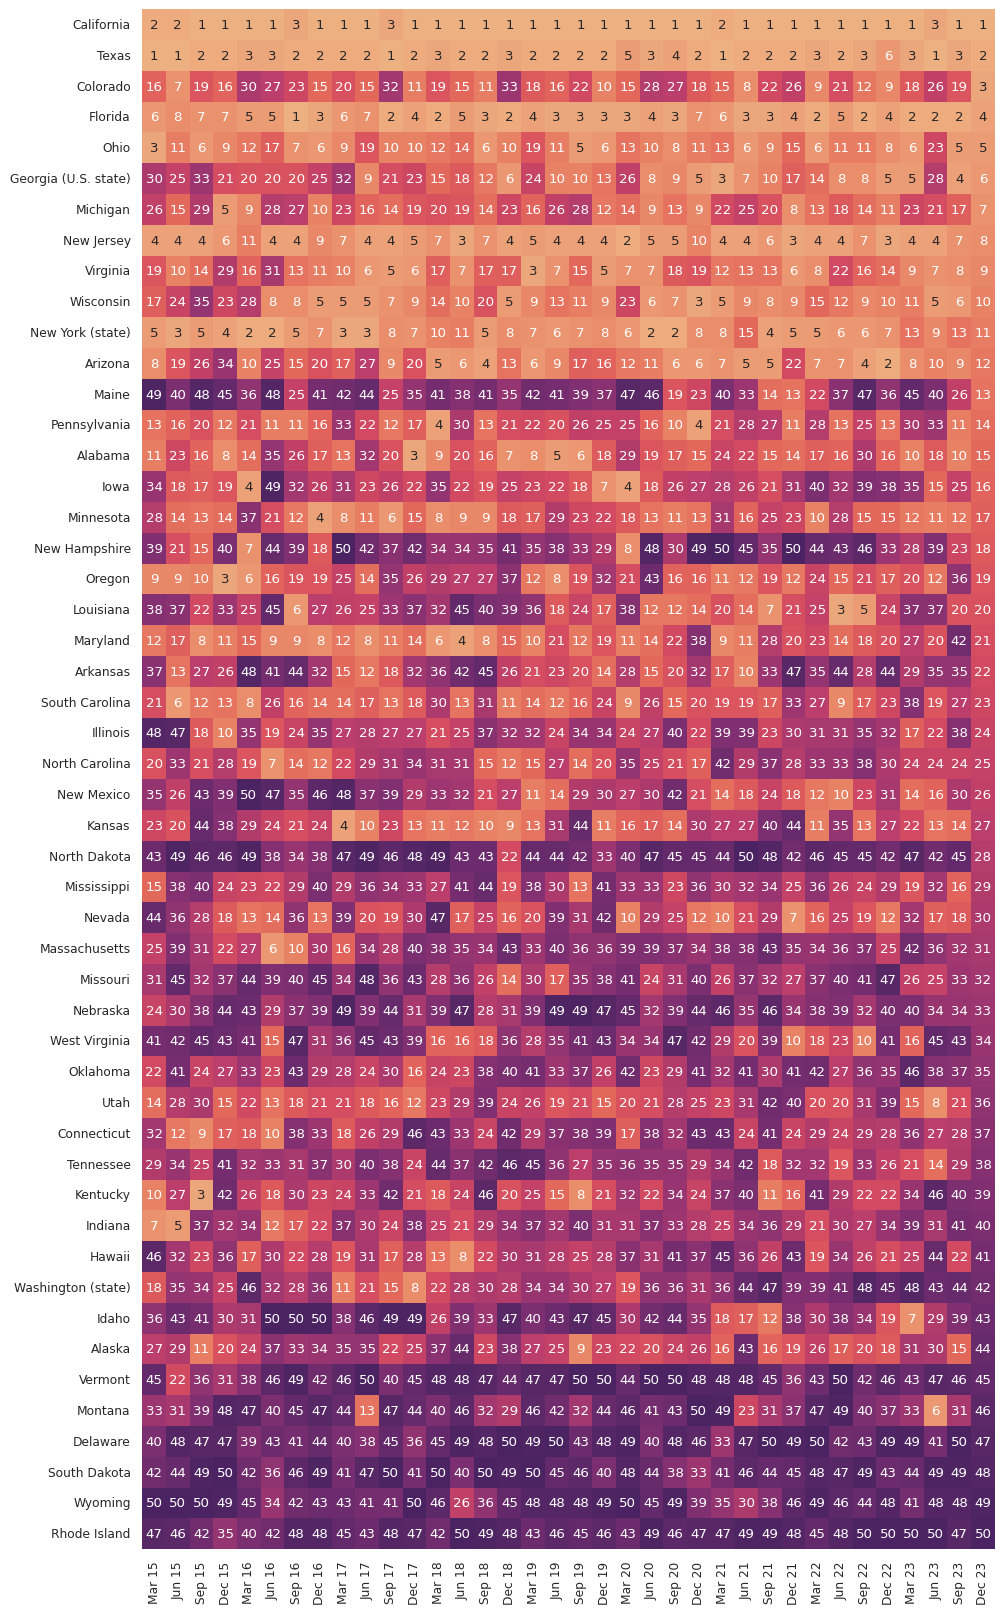

In [24]:
chart_keys, chart_ids = resolve_summary_ids([
    'Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California',
    'Colorado', 'Connecticut', 'Delaware', 'Florida', 'Georgia (U.S. state)',
    'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa',
    'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland',
    'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi', 'Missouri',
    'Montana', 'Nebraska', 'Nevada', 'New Hampshire', 'New Jersey',
    'New Mexico', 'New York (state)', 'North Carolina', 'North Dakota', 'Ohio',
    'Oklahoma', 'Oregon', 'Pennsylvania', 'Rhode Island', 'South Carolina',
    'South Dakota', 'Tennessee', 'Texas', 'Utah', 'Vermont',
    'Virginia', 'Washington (state)', 'West Virginia', 'Wisconsin', 'Wyoming',
])
chart_summary = summary_ranks[chart_ids]
chart_ranks = np.zeros_like(chart_summary, dtype=np.int64)
np.put_along_axis(chart_ranks,
                  chart_summary.argsort(axis=0),
                  1 + np.repeat(np.arange(chart_summary.shape[0])[:, np.newaxis], time_points, axis=1),
                  0)
chart_summary_order = chart_ranks[:, -1].argsort()
chart_ranks = chart_ranks[chart_summary_order]
chart_keys = np.array(chart_keys)[chart_summary_order].tolist()
fig, ax = plt.subplots(figsize=(11, 20))
ax = sns.heatmap(chart_ranks,
                 xticklabels=[dt.astype(datetime).strftime("%b %y") for dt in date_ser],
                 yticklabels=chart_keys,
                 ax=ax,
                 cmap='flare',
                 cbar=False,
                 annot=True)

In [25]:
id_map["New York (state)"]

1333964

In [29]:
pager(PR.with_columns(pl.Series("relevance", relevance)).filter(pl.col("relevance") > 0).sort("relevance", descending=True), 20)

interactive(children=(IntSlider(value=14604, description='page', max=29208), Output()), _dom_classes=('widget-…

<function nbhelpers.polars.pager.<locals>.<lambda>(page)>

In [30]:
with open(files.in_degree_filename, "rb") as fp:
    in_degree = np.load(fp)
with open(files.out_degree_filename, "rb") as fp:
    out_degree = np.load(fp)

In [43]:
titles_in_node_order_tbl = pyarrow.table({
    "k": pyarrow.array(id_map.keys(), size=len(id_map)),
    "v": pyarrow.array(id_map.values(), size=len(id_map)),
})

In [44]:
titles_in_node_order = titles_in_node_order_tbl.sort_by("v").columns[0]
titles_in_node_order

[
  [
    "Anarchism",
    "Albedo",
    "A",
    "Alabama",
    "Achilles",
    ...
    "Roman civil war of 432",
    "Cloud Script",
    "Mark Gilbert (disambiguation)",
    "Claudette Cayrol",
    "Gerard O'Brien (judge)"
  ]
]

In [32]:
def perplexity(distribution):
    return np.power(2, np.sum(-distribution * np.log2(distribution)))

def personalized_page_rank(preference, threshold=1, random_jump_prob=0.15):
    global files
    global N
    global in_degree
    global out_degree
    current_rank = np.ones(N, dtype=np.float64) / N
    next_rank = np.zeros(N, dtype=np.float64)
    # iteratively update current_rank
    edge_follow_prob = 1 - random_jump_prob
    prev_perplexity = float('inf')
    current_perplexity = perplexity(current_rank)
    current_iter = 0
    iter_start = time.time()
    print("Itr# | ΔPerplexity     | Seconds")
    while abs(prev_perplexity - current_perplexity) > threshold:
        current_iter += 1
        next_rank[:] = random_jump_prob * preference
        # update destinations from non-sink nodes (N x N times N x 1 -> N x 1)
        spread_probs = np.vstack([
            adjacency_matrix_slice.dot(current_rank[:, np.newaxis])
            for adjacency_matrix_slice in map(scipy.sparse.load_npz, files.adjacency_filenames(NUM_PARTITIONS))
        ])
        next_rank += edge_follow_prob * spread_probs[:, 0]  # make column vector 1-D
        # update destinations from sink nodes
        next_rank[:] += edge_follow_prob * current_rank[out_degree == 0].sum() / N
        # copy `next_rank` values into `current_rank``
        current_rank[:] = next_rank
        # --
        # compute perplexity and progress
        prev_perplexity = current_perplexity
        current_perplexity = perplexity(current_rank)
        next_iter_start = time.time()
        print("{:<3d}    {:<15.6f}   {:.3f}".format(current_iter,
                                                    current_perplexity - prev_perplexity,
                                                    next_iter_start - iter_start))
        iter_start = next_iter_start
    df = pl.DataFrame({
        "title": titles_in_node_order, "value": next_rank, "in_deg": in_degree, "out_deg": out_degree,
    })
    return df

In [33]:
relevance /= relevance.sum()

In [34]:
PPR = personalized_page_rank(relevance)

Itr# | ΔPerplexity     | Seconds
1      -6428502.414407   6.795
2      31640.950110      5.908
3      -38755.643899     5.822
4      -14152.452390     5.673
5      -12379.657408     6.980
6      -7137.488557      6.542
7      -5486.833853      6.796
8      -3616.664549      6.135
9      -2673.192569      5.879
10     -1858.360257      5.732
11     -1359.534311      5.822
12     -968.503783       5.798
13     -710.340062       4.954
14     -512.958020       4.747
15     -378.321203       5.000
16     -276.081735       5.659
17     -204.689685       4.781
18     -150.621982       5.270
19     -112.287082       5.807
20     -83.142393        5.354
21     -62.307542        4.942
22     -46.374378        5.729
23     -34.911575        5.902
24     -26.097734        5.581
25     -19.727808        5.226
26     -14.800384        5.064
27     -11.229367        4.931
28     -8.450558         5.275
29     -6.432671         5.321
30     -4.853642         5.338
31     -3.705672         5.175
32    

In [48]:
PPR.write_parquet(files.redditrank_parquet_filename)

In [49]:
PPR_sorted = PPR.sort("value", descending=True)

In [50]:
pager(PPR_sorted.slice(0, 2000), 20)

interactive(children=(Dropdown(description='page', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, …

<function nbhelpers.polars.pager.<locals>.<lambda>(page)>

In [51]:
searcher(
    PPR_sorted.slice(0, 200000).with_columns(pl.Series("rank", range(200000))).select(["rank", *PPR_sorted.columns]),
    ['title'],
    20
)

interactive(children=(Text(value='', description='q'), Output()), _dom_classes=('widget-interact',))

<function nbhelpers.polars.searcher.<locals>.searcher_run(q)>